# Autoregressive Transformer in Pytorch

similar to GPT architecture
https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf

some differences: RELU instead of GELU

Trained on WMT since this was the dataset used by the original Attention is all you need paper, and the decoder module used is shared with that architecture

Data was downloaded manually from https://nlp.stanford.edu/projects/nmt/ since torchnlp seems to be broken

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
from collections import OrderedDict
from functools import partial
import importlib
import matplotlib.pyplot as plt
import math
import numpy as np
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from src import data
from src import torch_models as models
from src import train_utils
import src.utils as utils

# reload during active development
importlib.reload(data)
importlib.reload(models)

<module 'src.torch_models' from '/mnt/ml_implementations/torch/attention/src/torch_models.py'>

In [4]:
import logging
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Train tokenizer using BBPE

"Sentences were encoded using byte-pair encoding [3], which has a shared sourcetarget vocabulary of about 37000 tokens"

Use tokenizers from huggingface

In [5]:
train_path_en = 'data/train.en'
train_path_de = 'data/train.de'
tokenizer_path = "data/tokenizer-bbpe-joint.json"

In [6]:
bbpe = data.get_bbpe_tokenizer(tokenizer_path, data_file_list=[train_path_en, train_path_de])

INFO:root:loading BBPE tokenizer at data/tokenizer-bbpe-joint.json


In [7]:
encoding = bbpe.encode(
    'this is a test sentence for byte pair encoding outofvocabword')
print(encoding.ids)
bbpe.decode(encoding.ids)

[3120, 336, 1818, 267, 21573, 277, 3099, 1019, 1203, 4027, 286, 10936, 316, 22466, 1014, 512, 6690, 9969, 85, 2143, 536, 24299]


'this is a test sentence for byte pair encoding outofvocabword'

## Build Model

### Small model for testing

In [8]:
importlib.reload(models)
importlib.reload(train_utils)
max_seqlen = 64
model_config = models.ModelConfig(
    dim=512,
    N=2,
    h=8,
    V=bbpe.get_vocab_size(),
    max_context=max_seqlen,
    drop_rate=0.01,
    position_encoding_class=models.LearnablePositionalEncoding,
)

model_config_large = models.ModelConfig(
    dim=512,
    N=8,
    h=8,
    V=bbpe.get_vocab_size(),
    max_context=max_seqlen,
    drop_rate=0.01,
    position_encoding_class=models.LearnablePositionalEncoding,
)

In [9]:
# for testing
seqlen = 22
tokens = [1] * seqlen
tokens = torch.tensor(tokens).unsqueeze(0)

In [10]:
model_autoreg = models.Autoregressive.from_config(model_config)
_ = model_autoreg.apply(train_utils.init_ones)
model_autoreg(tokens)

tensor([[[409.7980, 409.7980, 409.7980,  ..., 409.7979, 409.7979, 409.7979],
         [539.5802, 539.5802, 539.5802,  ..., 539.5815, 539.5815, 539.5815],
         [454.0135, 454.0135, 454.0135,  ..., 454.0151, 454.0151, 454.0151],
         ...,
         [599.6292, 599.6292, 599.6292,  ..., 599.6282, 599.6282, 599.6282],
         [478.8693, 478.8693, 478.8693,  ..., 478.8710, 478.8710, 478.8710],
         [466.7212, 466.7212, 466.7212,  ..., 466.7206, 466.7206, 466.7206]]],
       grad_fn=<AddBackward0>)

###  min gpt as control

https://github.com/karpathy/minGPT

Compare output with minGPT to make sure everything is working as expected

In [11]:
from src.minGPT.mingpt import model as min_gpt
from src.minGPT.mingpt.trainer import Trainer, TrainerConfig

In [12]:
#tconf = TrainerConfig(max_epochs=10, batch_size=256)
#trainer = Trainer(model, train_gen, train_gen, tconf)
#trainer.train()

mconf = min_gpt.GPTConfig(bbpe.get_vocab_size(),
                          model_config.max_context,
                          n_layer=model_config.N,
                          n_head=model_config.h,
                          n_embd=model_config.dim)
mgmodel = min_gpt.GPT(mconf)

INFO:src.minGPT.mingpt.model:number of parameters: 3.706163e+07


In [13]:
mgmodel.load_state_dict(torch.load(f'./saved_models/mingpt_n2_h8_d512_c64/1400'))

<All keys matched successfully>

In [14]:
print('Number of params in min GPT:', sum(p.numel() for p in mgmodel.parameters()))

Number of params in min GPT: 37061632


In [16]:
print('Number of params in implementation:', sum(p.numel() for p in model_autoreg.parameters()))

Number of params in implementation: 37087539


## Data Pipelines

In [15]:
if 'train_lines' not in locals():
    train_lines = sum(1 for line in open(data.TRAIN_PATH_EN, encoding='utf-8'))
if 'test_lines' not in locals():
    test_lines = sum(1 for line in open(data.TEST_PATH_EN, encoding='utf-8'))
print(f'train lines: {train_lines}')
print(f'test lines: {test_lines}')

train lines: 4468840
test lines: 2737


In [16]:
os.cpu_count()

48

### training/ data params

docs: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

In [53]:
importlib.reload(data)
dataset_config = data.DatasetConfig(bbpe, model_config_large.max_context)
tok_fn = partial(data.str_to_tok, add_start=False)
tok_fn_w_start = partial(data.str_to_tok, add_start=True)

def input_fn(en_line, de_line, data_config):
    en_input = data.str_to_tok(en_line, data_config, add_start=True)
    return [en_input]

def target_fn(en_line, de_line, data_config):
    return data.str_to_tok(en_line, data_config, add_start=False)

batch_size = 64

 Training would be more efficient with seqlen-aware batching, but for now a first order implementation is sufficient

In [50]:
# autoregressive training
importlib.reload(data)

train_dataset_autoreg = data.WMT2014Mixing(
    num_pools=7919,  # pick a prime number
    start_line=0,
    end_line=train_lines,
    process_inputs=input_fn,
    process_target=target_fn,
    dataset_config=dataset_config,
    train=True,
    overwrite_de_path=data.TRAIN_PATH_EN,
)
train_loader_autoreg = torch.utils.data.DataLoader(
    train_dataset_autoreg,
    batch_size=batch_size,
    pin_memory=True,
)

test_dataset_autoreg = data.WMT2014Mixing(
    num_pools=101,  # pick a prime number
    start_line=0,
    end_line=test_lines,
    process_inputs=input_fn,
    process_target=target_fn,
    dataset_config=dataset_config,
    train=False,
    overwrite_de_path=data.TEST_PATH_EN,
)
test_loader_autoreg = torch.utils.data.DataLoader(
    test_dataset_autoreg,
    batch_size=batch_size,
    pin_memory=True,
)

INFO:root:Loading existing line breaks for file data/train.en at data/train.en_linebreaks.pickle
INFO:root:Loading existing line breaks for file data/train.en at data/train.en_linebreaks.pickle
INFO:root:IterShuffleMixin: Initializing 7919 pools with 564 lines per pool
INFO:root:Loading existing line breaks for file data/test/newstest2014.en at data/test/newstest2014.en_linebreaks.pickle
INFO:root:Loading existing line breaks for file data/test/newstest2014.en at data/test/newstest2014.en_linebreaks.pickle
INFO:root:IterShuffleMixin: Initializing 101 pools with 27 lines per pool


## Training

Paper uses:

- emb_dimension, attn_dimension = 512
- n_heads = 8
- p_drop = 0.1
- N = 6
- train steps 100k

We have less compute so need to scale down the model to fit on one GPU

In [51]:
#loss_histories = dict()
with open('./saved_models/loss_histories.pickle', 'rb') as f:
    loss_histories = pickle.load(f)
loss_histories.keys()

dict_keys(['mingpt_n2_h8_d512_c64', 'autoreg_n2_h8_d512_c64_wproj_xavier', 'autoreg_n2_h8_d512_c64_wproj_mingptinit', 'autoreg_n2_h8_d512_c64_wproj_mingptinit_learnablepe', 'autoreg_n2_h8_d512_c64_wproj_mingptinit_learnablepe_shuffle', 'autoreg_n8_h8_d512_c64_wproj_mingptinit_learnablepe_shuffle'])

In [23]:
importlib.reload(train_utils)
importlib.reload(data)

_ = model_autoreg.apply(train_utils.min_gpt_init_weights)
train_utils.train_autoregressive(
    model_autoreg,
    loss_histories,
    'autoreg_n2_h8_d512_c64_wproj_mingptinit_learnablepe_shuffle',
    'cuda',
    train_loader_autoreg,
    test_loader_autoreg,
    dataset_config,
)

60 6.4260663986206055
80 6.399242877960205
100 6.249401569366455
120 6.138819217681885
140 5.903835296630859
160 5.72847318649292
180 5.541126251220703
200 5.34946346282959
220 5.3388285636901855
240 5.214876174926758
260 5.090947151184082
280 5.006117343902588
300 4.968453407287598
320 4.794905662536621
340 4.8333940505981445
360 4.816373825073242
380 4.795133590698242
400 4.683652877807617
420 4.760648250579834
440 4.551636219024658
460 4.597968578338623
480 4.599761486053467
500 4.492603778839111
520 4.573078155517578
540 4.4064812660217285
560 4.560678005218506
580 4.537132740020752
600 4.426883220672607
620 4.428097248077393
640 4.292205333709717
660 4.424023628234863
680 4.543357849121094
700 4.469935417175293
720 4.338676929473877
740 4.391097068786621
760 4.280434608459473
780 4.058974266052246
800 4.397448539733887
820 4.3116068840026855
840 4.217288970947266
860 4.14336633682251
880 4.164153575897217
900 4.279757022857666
920 4.21989631652832
940 4.125980854034424
960 4.16847

### train larger model

In [52]:
importlib.reload(models)
importlib.reload(train_utils)
importlib.reload(data)
importlib.reload(utils)

model_autoreg_large = models.Autoregressive.from_config(model_config_large)
_ = model_autoreg_large.apply(train_utils.min_gpt_init_weights)
train_utils.train_epoch(
    model_autoreg_large,
    loss_histories,
    'autoreg_n8_h8_d512_c64_wproj_mingptinit_learnablepe_shuffle',
    'cuda',
    train_loader_autoreg,
    test_loader_autoreg,
    dataset_config,
    save_every=100000,
    eval_every=10000,
    save_state_only=True,
)

INFO:root:saving models to ./saved_models/autoreg_n8_h8_d512_c64_wproj_mingptinit_learnablepe_shuffle
  0%|          | 157/69826 [01:03<41:23:03,  2.14s/it]

       10048: training loss 5.741561412811279, test loss 5.889643857645434


  0%|          | 313/69826 [02:06<42:14:56,  2.19s/it]

       20032: training loss 4.7029547691345215, test loss 5.211967368458593


  1%|          | 625/69826 [04:07<50:10:25,  2.61s/it]

       40000: training loss 4.510544776916504, test loss 4.802123280458672


  2%|▏         | 1250/69826 [07:58<40:58:56,  2.15s/it]

       80000: training loss 4.143743515014648, test loss 4.520741950633914


  4%|▎         | 2500/69826 [15:37<40:33:51,  2.17s/it]

      160000: training loss 3.618058681488037, test loss 4.215647070906883


  7%|▋         | 5000/69826 [30:45<40:24:35,  2.24s/it]

      320000: training loss 3.5267579555511475, test loss 3.9713637274365094


 14%|█▍        | 10000/69826 [1:01:07<35:48:41,  2.15s/it]

      640000: training loss 3.2002744674682617, test loss 3.7635177235270656


 29%|██▊       | 20000/69826 [2:14:13<36:37:33,  2.65s/it]

     1280000: training loss 2.840376853942871, test loss 3.5856786550477495


 37%|███▋      | 25616/69826 [2:55:05<5:41:26,  2.16it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 48%|████▊     | 33793/69826 [3:54:24<5:09:25,  1.94it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 57%|█████▋    | 40000/69826 [4:39:40<19:54:22,  2.40s/it]

     2560000: training loss 2.9144368171691895, test loss 3.4298356688299845


 58%|█████▊    | 40800/69826 [4:45:32<3:18:20,  2.44it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 70%|██████▉   | 48535/69826 [5:41:48<2:25:42,  2.44it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 99%|█████████▉| 69296/69826 [8:11:06<03:31,  2.50it/s]  

In [54]:
with open('./saved_models/loss_histories.pickle', 'wb') as f:
    pickle.dump(loss_histories, f)

# Analysis of small models (n=2)

### Some observations
- Initialization doesn't matter here for these models, sim to reported in GPT paper
- Adding an extra projection (Attn is all you need vs. GPT) makes very little difference
- GELU vs RELU doesn't make much of a difference at this scale/ on this dataset
- Raw WMT14 data is non-random and needs to be pseudo-shuffled
- **Learnable positional encoding makes by far the largest difference**


In [56]:
def plot_avg(series, window, *args, **kwargs):
    avgs = []
    for i in range(0, len(series), window):
        avgs.append(np.mean(series[i:i+window]))
    plt.plot(avgs, *args, **kwargs)

###  min GPT vs implementation

Main difference seems to be the use of learnable position embeddings (PE), which the "attention is all you need" did not use but is used in modern attention architectures.

Initialization does not make much difference, although minGPT seems slightly better.

Note we train << 1 epoch to save time

Text(0.5, 1.0, 'training curves for different implementations')

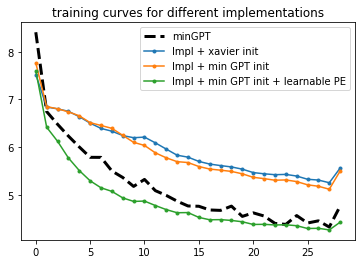

In [80]:
window = 50
plot_avg(loss_histories['mingpt_n2_h8_d512_c64'], window, 'k--', linewidth=3)
plot_avg(loss_histories['autoreg_n2_h8_d512_c64_wproj_xavier'], window, '.-')
plot_avg(loss_histories['autoreg_n2_h8_d512_c64_wproj_mingptinit'], window, '.-')
plot_avg(loss_histories['autoreg_n2_h8_d512_c64_wproj_mingptinit_learnablepe'], window, '.-')
plt.legend(['minGPT', 'Impl + xavier init', 'Impl + min GPT init', 'Impl + min GPT init + learnable PE'])
plt.title('training curves for different implementations')

### Data periodicity

There is some strange periodicity in the loss function which suggest that the data is not uniformly distributed. Because the data came in a single file, we built an iterator-based dataset which does not enable shuffling. This was fixed in the `WMT14Mixing` class.

(0.0, 500.0)

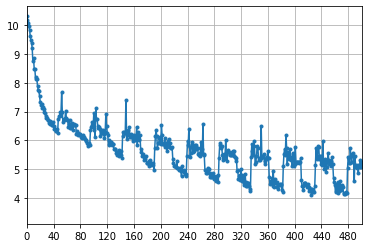

In [42]:
plt.figure()
plt.grid(which='both')
plt.xticks(range(0, 1400, 40))
window = 1
plot_avg(loss_histories['autoreg_n2_h8_d512_c64_wproj_mingptinit_learnablepe'], window, '.-')
plt.xlim([0, 500])

In [43]:
def read_line_at_batch(batch_id):
    line_num = batch_id * batch_size
    with open(data.TRAIN_PATH_EN, 'r', encoding='utf-8') as f:
        f.seek(train_dataset.en_linebreaks[line_num], 0)
        print(f.readline())

In [47]:
print('hard line')
read_line_at_batch(300)
print('easy line')
read_line_at_batch(360)

hard line
 of soldiers , I tell the girls to get out of the car .

easy line
 town .



We see that some lines are mostly not in English 

In [48]:
print('hard line')
read_line_at_batch(160) # hard
print('easy line')
read_line_at_batch(200) # easy

hard line
ay at the Pousadas de Compostela Hotel Airas Nunes ?

easy line
t be tempted to walk back to your hotel unless you are close by .



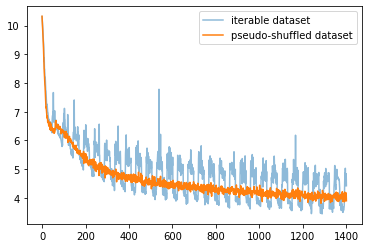

In [79]:
plt.plot(loss_histories['autoreg_n2_h8_d512_c64_wproj_mingptinit_learnablepe'], alpha=.5)
plt.plot(loss_histories['autoreg_n2_h8_d512_c64_wproj_mingptinit_learnablepe_shuffle'])
plt.legend(['iterable dataset', 'pseudo-shuffled dataset'])

Previous experiments show that gradient clipping makes little difference 

## Analysis of large model (n = 8)
trained for 1 epoch only due to time/ compute constraints

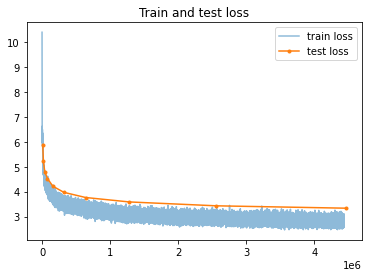

In [78]:
plt.plot(*zip(*loss_histories['autoreg_n8_h8_d512_c64_wproj_mingptinit_learnablepe_shuffle']['train_loss']), alpha=.5)
plt.plot(*zip(*loss_histories['autoreg_n8_h8_d512_c64_wproj_mingptinit_learnablepe_shuffle']['test_loss']), '.-')
plt.title('Train and test loss')
plt.legend(['train loss', 'test loss'])

## Sampling

The larger model is slightly better than the smaller model but both are very, very far from current sota

In [100]:
model_autoreg.load_state_dict(
    torch.load(
        'saved_models/autoreg_n2_h8_d512_c64_wproj_mingptinit_learnablepe_shuffle/1400'
    ))

<All keys matched successfully>

In [212]:
importlib.reload(utils)
utils.sample_autoregressive(model_autoreg, '', 10, dataset_config)

b'The hotel offers cost old all solders with a'

In [211]:
utils.sample_autoregressive(mgmodel, '', 10, dataset_config)

b'When would you like to stay at the Gift'

In [85]:
utils.sample_autoregressive(model_autoreg_large, '', 20, dataset_config)

b'We consider that the deficit has to do away with the revenues from fossil fu'

In [102]:
utils.sample_autoregressive(model_autoreg, 'The big white dog', 20, dataset_config)

b'The big white dog are twinnesses to the authority where his transport is some otherone being close to'

In [109]:
utils.sample_autoregressive(model_autoreg_large, 'The big white dog', 20, dataset_config)

b'The big white dog was amazing white on the stone site of The North Neckland , following'

In [111]:
utils.sample_autoregressive(model_autoreg, 'My favorite food is ', 20, dataset_config)

b'My favorite food is co release . closedness .\n'

In [110]:
utils.sample_autoregressive(model_autoreg_large, 'My favorite food is ', 20, dataset_config)

b'My favorite food is either a smoke bag of roulette or a glass of Alsa , though'